In [3]:
import copy
import sys
import time
sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
from torch.optim import Adam
# import seaborn as sns

from gglm.glm.cimmdglm import CIMMDGLM
from gglm.glm.torchglm import TorchGLM
# from gglm.cnncritic import MMDCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from gglm.metrics import bernoulli_log_likelihood_poisson_process
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from kernel.values import KernelBasisValues
from gglm.metrics import time_rescale_transform

from signals import auto_covariance

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1', chen='C4')    

In [4]:
def plot_layout():
    fig = plt.figure(figsize=(12, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
    ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
    ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
    ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
    ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
    ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43)

def plot_layout2():
    ncols = 3
    r1, r2 = 2, 1
    nrows = 3 * r1
    fig = plt.figure(figsize=(10, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1)
#     ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), rowspan=r1, colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
#     ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax31 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, ncols - 1), rowspan=r1, colspan=1)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), colspan=ncols - 1)
#     ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
#     ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
#     ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax10, ax11, ax20, ax30, ax31, ax40)

def plot_layout3(f):
    r1, r2, r3 = 1, 2, 1
    c1, c2, c3 = 3, 2, 1
    nrows = 2 * r2
    ncols = c1 + 2 * c2
    fig = plt.figure(figsize=(2 * f, 1 * f))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1, colspan=c1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, c1), rowspan=r3, colspan=c3)
    ax01b = plt.subplot2grid((nrows, ncols), (r1, c1), rowspan=r3, colspan=c3)
    ax01c = plt.subplot2grid((nrows, ncols), (0, c1 + c3), rowspan=1, colspan=c3)
    ax02 = plt.subplot2grid((nrows, ncols), (0, c1 + 2 * c3), rowspan=r2, colspan=c2)
#     ax02 = plt.subplot2grid((nrows, ncols), (0, c1 +  2 * c3), rowspan=r2, colspan=c2)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), rowspan=r1, colspan=c1, sharex=ax00)
    ax20 = plt.subplot2grid((nrows, ncols), (2 * r1, 0), rowspan=r1, colspan=c1, sharex=ax00)
    ax21 = plt.subplot2grid((nrows, ncols), (2 * r1, c1), rowspan=r2, colspan=c2)
    ax22 = plt.subplot2grid((nrows, ncols), (2 * r1, c1 + c2), rowspan=r2, colspan=c2)
    ax30 = plt.subplot2grid((nrows, ncols), (3 * r1, 0), rowspan=r1, colspan=c1, sharex=ax00)
    return fig, (ax00, ax01, ax01b, ax01c, ax02, ax10, ax20, ax21, ax22, ax30)

# plot_layout3(8)

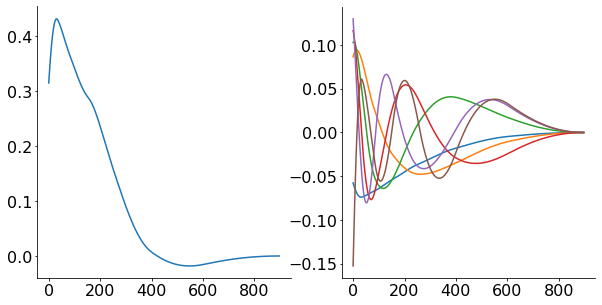

In [47]:
from scipy.io import loadmat
basis = loadmat('./basis.mat')['a']

# eta = KernelBasisValues(X_eta, [0, 1000], 1, coefs=[-5, 1, -0.75, 0.5, -0.2,  0.1, -0.05])
t_ker = np.arange(0, basis.shape[0], 1)
eta = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=[-5, 1, -0.75, 0.5, -0.2,  0.1])
eta_vals = eta.interpolate(np.arange(0, 898, 1))
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(eta_vals)
ax2.plot(basis)

# args = np.where(shift_array(mask_spikes_train, 1, fill_value=False))
# t_spk = (t[args[0]],) + args[1:]
# X = eta.convolve_basis_discrete(t, t_spk, shape=mask_spikes_train.shape)
# fig, ax = plt.subplots()
# ax.plot(X[:, 0, :])

In [6]:
# path = "./Data_Fig9A.mat"
# mat9a = loadmat(path)
# aux = mat9a['all_wf_mean']
# aux2 = mat9a['all_wfs']

# path = "./Data_Fig9B.mat"
# mat9b = loadmat(path)

In [7]:
# plt.plot(np.concatenate((aux2[0][0])).T)

(array([2.87889775e-02, 2.87164612e-02, 2.03045685e-02, 1.05148658e-02,
        5.29369108e-03, 2.53807107e-03, 1.59535896e-03, 2.90065265e-04,
        4.35097897e-04, 2.17548949e-04, 2.90065265e-04, 1.45032632e-04,
        2.90065265e-04, 2.17548949e-04, 1.45032632e-04, 7.25163162e-05,
        0.00000000e+00, 7.25163162e-05, 7.25163162e-05]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <a list of 19 Patch objects>)

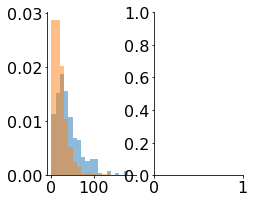

In [8]:
path = "/home/diego/python/generative-glm/cool_stuff/h5test.h5"
f = h5py.File(path, "r")

arg_spikes = (np.array(f['MC']['spikeTimes'], dtype=int)[:, 0], np.array(f['MC']['spikeIndices'], dtype=int)[:, 0] - 1)

dt = 1
t = np.arange(0, 1000, dt)
mask_spikes = np.zeros((len(t), 10), dtype=bool)
mask_spikes[arg_spikes] = True

n_train = 10
mask_spikes_train = mask_spikes[:, :n_train]
n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)
autocov_train = np.mean(auto_covariance(mask_spikes_train, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)
# mask_spikes_val = mask_spikes[:, n_train:]
# fr_val = np.mean(np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000)

# mask_inh = np.array(loadmat('./monkey_pmv_inhomo.mat')['pseudo_all_spike_trainInHomo'].T, dtype=bool)
mask_inh = np.array(loadmat('./monkey_pmv_inh.mat')['pseudo_all_spike_trainInHomo'].T, dtype=bool)
st_inh = SpikeTrain(np.arange(0, mask_inh.shape[0], 1), mask_inh)
isi_inh = st_inh.isi_distribution()
autocov_inh = np.mean(auto_covariance(mask_inh, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)

st_train = SpikeTrain(t, mask_spikes_train)
isi_train = st_train.isi_distribution()
mean_isi_train = np.mean(isi_train)
bins = np.arange(0, 200, 10)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.hist(isi_train, density=True, bins=bins, alpha=0.5)
ax1.hist(isi_inh, density=True, bins=bins, alpha=0.5)

# st_val = SpikeTrain(t, mask_spikes_val)
# isi_val = st_val.isi_distribution()
# mean_isi_val = np.mean(isi_val)

In [9]:
def fun_metrics_ml(model, t, mask_spikes, X):
    n_batch_fr = 25
    T = st_train.t[-1] - st_train.t[0] + st_train.t[1]
    u_fr, r_fr, mask_spikes_fr = model.sample(st_train.t, shape=(n_batch_fr,))
    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr = np.mean(fr)
    return dict(mu_fr=mu_fr)

### ML

In [10]:
# def raised_cosine(t, b, c, dc, a=1e0):
#     basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
#     basis = basis / np.sqrt(np.sum(basis**2, 0))
#     u, s, v = np.linalg.svd(basis)
#     basis = u[:, :basis.shape[1]]
#     return basis

# # n = 6
# # last_peak = 400
# # b = last_peak / 5
# # peak0 = 0

# n = 6
# last_peak = 200
# b = last_peak / 7
# peak0 = 0

# yrnge = np.log(np.array([0, last_peak]) + b)
# db = np.diff(yrnge) / (n - 1)
# ctrs = np.arange(yrnge[0], yrnge[1] + db, db)
# mxt = np.exp(yrnge[1] + 2 * db) - b # max time bin
# print(mxt[-1])
# t_ker = np.arange(0, mxt[-1], dt)

# basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)

# fig, ax = plt.subplots(figsize=(12, 5))
# ax.plot(t_ker, basis)

In [11]:
coefs = np.zeros(basis.shape[1])
eta0 = KernelBasisValues(basis.copy(), [0, basis.shape[0]], 1, coefs=coefs)

lr = 1e-1
num_epochs = 200
n_metrics = 10

glm = TorchGLM(u0=-5, eta=eta0.copy(), noise='bernoulli')
# glm.metrics = fun_metrics_ml
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=fun_metrics_ml, n_metrics=n_metrics)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_train_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk_train

_, r_train_dc_ml = glm.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(st_train.mask.shape[1],))
# _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(200,))
# r_fr_ml = r_fr_ml * 1000
# st_fr_ml = SpikeTrain(st_train.t, mask_spikes_fr_ml)
# isi_fr_ml = st_fr_ml.isi_distribution()
# mean_isi_fr_ml = np.mean(isi_fr_ml)
# mean_r_fr_ml = np.mean(r_fr_ml, 1)
# sum_r_fr_ml = np.sum(r_fr_ml, 1)

t_long = np.arange(0, 3000, 1)
_, r_fr_ml_long, mask_spikes_fr_ml_long = glm.sample(t_long, shape=(10,))
st_fr_ml_long = SpikeTrain(t_long, mask_spikes_fr_ml_long)
isi_fr_ml = st_fr_ml_long.isi_distribution()
isi_fr_ml_long = st_fr_ml_long.isi_distribution()
mean_isi_fr_ml = np.mean(isi_fr_ml)
# autocov_ml_long = np.mean(auto_covariance(mask_spikes_fr_ml_long, method='fft', subtract_mean=False, stationary_signal=False, biased=False), 1)
_, _, mask_autocov = glm.sample(t_long, shape=(400,))
autocov_ml_long = np.mean(auto_covariance(mask_autocov, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)
z_ml, ks_ml = time_rescale_transform(dt, st_train.mask, r_train_dc_ml)
values, bins_ks = np.histogram(np.concatenate(z_ml), bins=100)
z_cum_ml = np.append(0., np.cumsum(values) / np.sum(values))

# r_train_dc_ml = r_train_dc_ml * 1000
# r_fr_ml_long = r_fr_ml_long * 1000

 epoch 199 of 200 nll 1112.0382

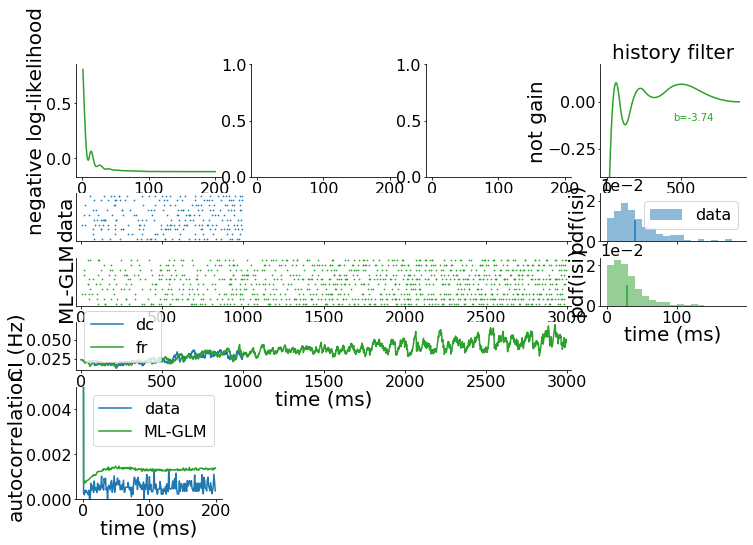

In [12]:
for key, val in metrics_ml.items():
    metrics_ml[key] = np.array(val)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig = plt.figure(figsize=(12, 8))
ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)

ax00.plot(iterations_ml, nll_normed_train_ml, color=palette['ml'])
# ax1.plot(iterations_ml, metrics_ml['nll_val'], color=palette['ml'])
myplt.set_labels(ax00, xlabel='iterations', ylabel='negative log-likelihood')

# ax2.plot(iterations_ml[::n_metrics], metrics_ml['mu_fr'], '-.', color=palette['ml'])
# ax2.plot([1, num_epochs + 1], [fr_train, fr_train], '--', color=palette['d'], label='data')
# # ax2.set_ylim(0, 25)
# myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
# ax2.legend()

glm.eta.plot(t=t_ker, ax=ax03, exp_values=False, color=palette['ml'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.set_ylim(-0.4, 0.2)

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_ml.plot(ax=ax5, ms=0.7, color=palette['ml'])
st_fr_ml_long.plot(ax=ax20, ms=0.7, color=palette['ml'])
ax20.set_yticks([])
ax20.set_ylabel('ML-GLM')

ax30.plot(t, np.mean(r_train_dc_ml, 1), color=palette['d'], label='dc')
ax30.plot(t_long, np.mean(r_fr_ml_long, 1), color=palette['ml'], label='fr')
ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

ax21.hist(isi_fr_ml, density=True, alpha=0.5, color=palette['ml'], label='ML-GLM', bins=bins)
ax21.plot([mean_isi_fr_ml, mean_isi_fr_ml], [0, y1], '-', color=palette['ml'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

argf = 200
ax40.plot(autocov_train[:argf], color=palette['d'], label='data')
ax40.plot(autocov_ml_long[:argf], color=palette['ml'], label='ML-GLM')
ax40.set_ylim(0, 5e-3)
myplt.set_labels(ax40, xlabel='time (ms)', ylabel='autocorrelation')
ax40.legend()

fig.subplots_adjust(hspace=0.35)

fig.savefig('/home/diego/Dropbox/generative_glm/figures/monkey_pmv/ML.pdf', transparent=True)

In [13]:
# from torch.nn.functional import conv1d

# k, e_dc, u, r_train_dc_ml = glm.sample_conditioned(st_train.t, st_train.mask, full=True)
# k, e_fr, _, r_fr_ml_long, mask_spikes_fr_ml_long = glm.sample(t_long, shape=(20,), full=True)

# model = glm

# r1 = torch.from_numpy(r_train_dc_ml)
# r2 = torch.from_numpy(r_fr_ml_long)

# eta1 = torch.log(r1) - model.b
# eta2 = torch.log(r2) - model.b

# # autocor1 = np.mean(auto_covariance(e_dc, subtract_mean=False, stationary_signal=False, biased=True), 1)
# # autocor2 = np.mean(auto_covariance(e_fr, subtract_mean=False, stationary_signal=False, biased=True), 1)
# autocor1 = np.mean(auto_covariance(eta1.detach().numpy(), subtract_mean=False, negative_times=False, 
#                                    stationary_signal=False, biased=True), 1)
# autocor2 = np.mean(auto_covariance(eta2.detach().numpy(), subtract_mean=False, negative_times=False, 
#                                    stationary_signal=False, biased=True), 1)

# T1, T2 = eta1.shape[0], eta2.shape[0]

# autocor1pt = conv1d(eta1.T[None, :, :], eta1.T[:, None, :], padding=(T1 - 1), groups=eta1.shape[1]) / T1
# autocor1pt = autocor1pt[0, :, (T1-1):].T

# autocor2pt = conv1d(eta2.T[None, :, :], eta2.T[:, None, :], padding=(T2 - 1), groups=eta2.shape[1]) / T2
# autocor2pt = autocor2pt[0, :, (T2-1):].T

# fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
# ax1.plot(autocor1)
# ax1.plot(autocor2)
# ax1.plot(torch.mean(autocor1pt, 1).detach(), '--')
# ax1.plot(torch.mean(autocor2pt, 1).detach(), '--')

In [14]:
# from torch.nn.functional import conv1d

# k, e_dc, u, r_train_dc_ml = glm.sample_conditioned(st_train.t, st_train.mask, full=True)
# # k, e_fr, _, r_fr_ml_long, mask_spikes_fr_ml_long = glm.sample(t_long, shape=(20,), full=True)

# model = glm

# r1 = torch.from_numpy(r_train_dc_ml)
# eta1 = torch.log(r1) - model.b

# T = eta1.shape[0]

# autocor1 = auto_covariance(eta1.detach().numpy(), subtract_mean=False, negative_times=False, 
#                                    stationary_signal=False, biased=True)

# # eta1 = eta1.T[:, None, :]
# # eta2 = eta2.T[:, None, :]

# # eta1 = eta1.T[None, :, :]
# autocor1pt = conv1d(eta1.T[None, :, :], eta1.T[:, None, :], padding=(eta1.shape[0] - 1), groups=10) / T
# autocor1pt = autocor1pt[:, :, (T-1):]
# # aux = torch.mean(autocor1pt.detach()[0], dim=0)[autocor1pt.shape[2] // 2:]

# # autocor1pt = conv1d(eta1, eta1, padding=(eta1.shape[2] - 1) // 2)


# fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
# ax1.plot(autocor1[:, 0])
# ax2.plot(autocor1[:, 1])
# ax1.plot(autocor1pt.detach()[0, 0, :])
# ax2.plot(autocor1pt.detach()[0, 1, :])

# # ax1.plot(aux)
# # ax1.plot(torch.mean(eta1.detach(), 0)[0, :])

# # conv1d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1)



### MMD

In [15]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    dt = 1
    T_train = t[-1] - t[0] + t[1]
    mu_fr = np.mean(np.sum(mask_spikes_fr.double().numpy(), 0)) / T_train * 1000
    return dict(mu_fr=mu_fr)

In [16]:
from torch.nn.functional import conv1d

def phi_id(t, r):
    return r * 1000

def kernel_id(t, r1, r2):
    return torch.sum(r1[:, :, None] * 1000 * r2[:, None, :] * 1000, 0)

def phi_mean(t, r):
    return torch.mean(r, 0)[None, :] * 1000

def phi_sum(t, r):
    return torch.sum(r  * 1000, 0)[None, :]

def phi_autocov(t, r, model):
    T = len(t)
    eta = torch.log(r) - model.b
    padding = 1000
    autocov = conv1d(eta.T[None, :, :], eta.T[:, None, :], padding=padding, groups=eta.shape[1]) / T
    autocov = autocov[0, :, (padding-1):].T
    return autocov
    
def kernel_expr(t, r1, r2):
    gramian = torch.exp(-torch.sum((r1[:, :, None] - r2[:, None, :])**2, 0) / sd2)
#     print(torch.sum((r1[:, :, None] - r2[:, None, :])**2, 0))
#     print(gramian)
    return gramian

dic_ker_strings = {'phi_id': "<r,r'>", 'phi_mean': "mu_r * mu_r'", 'phi_sum': "sum_r * sum_r'", 
                   'kernel_expr': "exp(-sum((r-r')^2)/sd^2)", 'kernel_id': "<r,r'>", 'phi_autocov': "<g, g'>"}
dic_ker_name = {'phi_id': "canonical_dot", 'phi_mean': 'means_product', 'phi_sum': "sum_product", 
               'kernel_expr': "gaussian", 'kernel_id': "canonical_dot", 'phi_autocov': "autocov"}

In [17]:
# phi, kernel, lam_mmd, biased, lr, clip = phi_id, None, 1e-2, True, 1e-2, 1e0 # hermosa solucion. satura
# phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 1e4, True, 1e-2, 1e0 # nice one
# phi, kernel, lam_mmd, biased, lr, clip = phi_id, None, 1e-2, False, 1e-2, 1e0
# phi, kernel, lam_mmd, biased, lr, clip = None, kernel_id, 1e-2, False, 1e-2, 1e0
# phi, kernel, lam_mmd, lr, clip = None, kernel_expr, 1e5, 1e-2, 1e0

# phi, kernel, lam_mmd, lr, clip = phi_sum, None, 1e0, 1e-2, 1e0 

phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 5e2, True, 1e-2, 1e0

beta0, beta1 = 0, 0
n_batch_fr = 60
n_metrics = 1
num_epochs = 250

time0 = time.time()
u00 = glm.u0
eta0 = glm.eta.copy()

# eta0_scaled = glm.eta.copy()
# eta0_scaled.coefs = eta0_scaled.coefs * 0.1
# mmdglm = CIMMDGLM(u0=glm.u0, eta=eta0_scaled.copy())

mmdglm = CIMMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=True, score_term=False,
                                               n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(st_train.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)

_, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(st_train.mask.shape[1],))
st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
_, _, mask_autocov = mmdglm.sample(t_long, shape=(400,))
autocov_mmd_long = np.mean(auto_covariance(mask_autocov, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)
z_mmd, ks_mmd = time_rescale_transform(dt, st_train.mask, r_dc_mmd)
values, bins_ks = np.histogram(np.concatenate(z_mmd), bins=bins_ks)
z_cum_mmd = np.append(0., np.cumsum(values) / np.sum(values))

# r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000
# r_fr_mmd_long = r_fr_mmd_long * 1000

time1 = time.time()
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 50 of 250 loss 1122.6839599609

KeyboardInterrupt: 

In [16]:
sd2=1

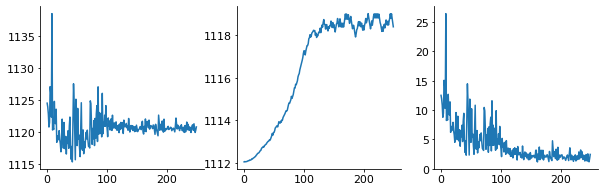

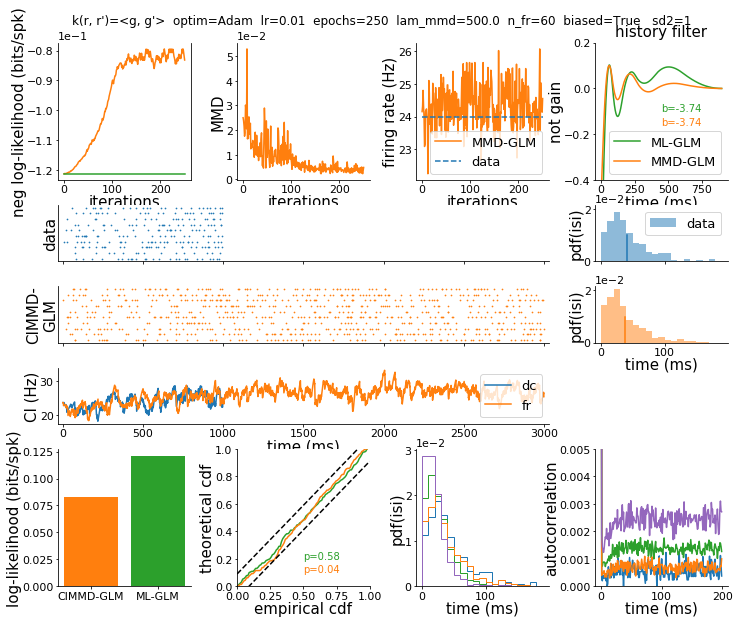

In [21]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

if phi is not None:
    ker_name = phi.__name__
else:
    ker_name = kernel.__name__
    
title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
     + '  epochs=' + str(num_epochs) + \
       '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased) + '   sd2=' + str(sd2)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
ax1.plot(loss_mmd)
ax2.plot(nll_train)
ax3.plot((loss_mmd - nll_train))
# ax3.set_ylim(0, 1e4)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout()
fig.suptitle(title, fontsize=12, y=0.92)

ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
          label='ML-GLM', color=palette['ml'])
ax00.spines['right'].set_visible(True)
ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax00.legend()
myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
yf = np.median(metrics_mmd['mmd'][-10:] * 2)
# ax01.set_ylim(-1e2, yf)
myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
# ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
ax02.legend()

glm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
ax03.legend()
ax03.set_ylim(-0.4, 0.2)

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

# ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
# ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
ax21.hist(isi_fr_mmd_long, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
ax21.plot([mean_isi_fr_mmd_long, mean_isi_fr_mmd_long], [0, y1], '-', color=palette['mmd'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
st_fr_mmd_long.plot(ax=ax20, ms=0.7, color=palette['mmd'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('CIMMD-\nGLM')

ax30.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
ax30.plot(t_long, np.mean(r_fr_mmd_long, 1), color=palette['mmd'], label='fr')
# ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')
ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

ax40.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
ax40.bar(1, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
# ax40.legend()
ax40.set_ylabel('log-likelihood (bits/spk)')
ax40.set_xticks([0, 1])
ax40.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])

# ax40.set_ylabel('log-likelihood (bits/spk)')

ax41.plot(bins_ks, z_cum_ml, color=palette['ml'], label='ML-GLM')
ax41.plot(bins_ks, z_cum_mmd, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml[1], 2)), color=palette['ml'], transform=ax41.transAxes)
ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

lw = 1
ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
ax42.hist(isi_fr_ml_long, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins)
ax42.hist(isi_fr_mmd_long, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins)
ax42.hist(isi_inh, density=True, alpha=1, color=palette['chen'], histtype='step', lw=lw, label='chen', bins=bins)
ax42.set_ylabel('pdf(isi)')
ax42.set_xlabel('time (ms)')
ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax42.legend()
# y1 = ax42.get_ylim()[1] / 2
# ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
# ax42.tick_params(axis='both', labelbottom=False)

argf = 200
ax43.plot(autocov_train[:argf], color=palette['d'], label='data')
ax43.plot(autocov_ml_long[:argf], color=palette['ml'], label='ML-GLM')
ax43.plot(autocov_mmd_long[:argf], color=palette['mmd'], label='MMD-GLM')
ax43.plot(autocov_inh[:argf], color=palette['chen'], label='chen')
ax43.set_ylim(0, 5e-3)
myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

# fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(hspace=0.45, wspace=0.35)

fig_name = 'cimmd_' + dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

import os
list_files = os.listdir('/home/diego/Dropbox/generative_glm/figures/monkey_pmv/')

ii = 1
while fig_name + '_' + str(ii) + '.pdf' in list_files:
    ii += 1
file_name = fig_name + '_' + str(ii) + '.pk'
fig_name += '_' + str(ii) + '.pdf'

fig.savefig('/home/diego/Dropbox/generative_glm/figures/monkey_pmv/' + fig_name, transparent=True)

import pickle
dic = dict(basis=basis, u0_ml=glm.u0, eta_coefs_ml=glm.eta.coefs, ker_name=ker_name, 
           lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_train, 
           metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

path = '/home/diego/Dropbox/generative_glm/figures/monkey_pmv/' + file_name
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)

In [22]:
import pickle
file_name = 'cimmd_autocov_lammmd500.0biasedTrue_epochs250_lr0.01_5.pk'

path = '/home/diego/Dropbox/generative_glm/figures/monkey_pmv/' + file_name
with open(path, "rb") as fit_file:
    dic = pickle.load(fit_file)

In [41]:
eta_ml = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=dic['eta_coefs_ml'])
eta_mmd = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=dic['eta_coefs_mmd'])
glm = TorchGLM(u0=dic['u0_ml'], eta=eta_ml)
mmdglm = TorchGLM(u0=dic['u0_mmd'], eta=eta_mmd)
loss_mmd = dic['loss_mmd']
nll_train = dic['nll_train']
nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
iterations_mmd = np.arange(1, len(loss_mmd) + 1, 1)

_, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(st_train.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)

_, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(st_train.mask.shape[1],))
st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
_, _, mask_autocov = mmdglm.sample(t_long, shape=(400,))
autocov_mmd_long = np.mean(auto_covariance(mask_autocov, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)
z_mmd, ks_mmd = time_rescale_transform(dt, st_train.mask, r_dc_mmd)
values, bins_ks = np.histogram(np.concatenate(z_mmd), bins=bins_ks)
z_cum_mmd = np.append(0., np.cumsum(values) / np.sum(values))

In [42]:
conv_ker = KernelFun.gaussian_delta(20)

psth_d = np.mean(st_train.convolve(conv_ker), 1) * 1000
psth_ml = np.mean(st_fr_ml_long.convolve(conv_ker), 1) * 1000
psth_mmd = np.mean(st_fr_mmd_long.convolve(conv_ker), 1) * 1000

# _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(st_train.mask.shape[1],))

phi_d_ml = phi_autocov(t, torch.from_numpy(r_train_dc_ml), glm)
phi_fr_ml = phi_autocov(t, torch.from_numpy(r_fr_ml), glm)
mmd_ml = (torch.sum((torch.mean(phi_d_ml.detach(), 1) - torch.mean(phi_fr_ml.detach(), 1))**2)).item()

phi_d_mmd = phi_autocov(t, torch.from_numpy(r_dc_mmd), mmdglm)
phi_fr_mmd = phi_autocov(t, torch.from_numpy(r_fr_mmd), mmdglm)
mmd_mmd = (torch.sum((torch.mean(phi_d_mmd.detach(), 1) - torch.mean(phi_fr_mmd.detach(), 1))**2)).item()

In [43]:
# tick_labelsize = 16
# f2 = 20
# dic = {'axes.titlesize': f2, 'axes.labelsize': f2, 'xtick.labelsize': tick_labelsize, 
#          'ytick.labelsize': tick_labelsize, 'legend.fontsize': tick_labelsize}
            
# for key, val in dic.items():
#     mpl.rcParams[key] = val

In [44]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

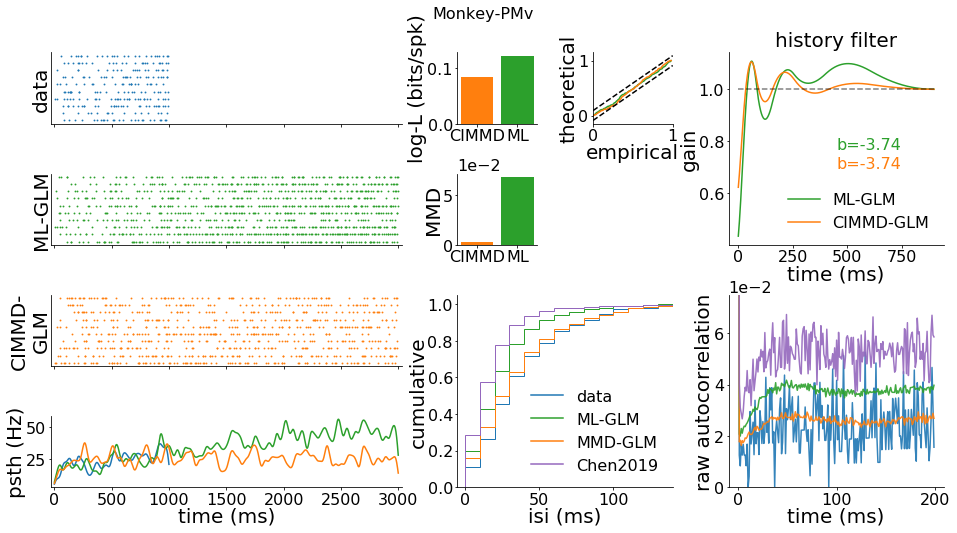

In [46]:
# fig, (axll, axpp, axeta, axd, axisi, axml, axmmd, axac, axpsth) = plot_layout2()
# fig.subplots_adjust(hspace=0.6, wspace=0.3)
# fig.suptitle('Monkey-PMv', fontsize=16, y=0.92)
fig, (axd, axll, axmmds, axpp, axeta, axml, axmmd, axisi, axac, axpsth) = plot_layout3(8)
fig.subplots_adjust(hspace=0.7, wspace=0.7)
fig.suptitle('Monkey-PMv', fontsize=16, y=0.96)

axll.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
axll.bar(1, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
# axll.set_ylabel('log-likelihood (bits/spk)')
axll.set_ylabel('log-L (bits/spk)')
axll.set_xticks([0, 1])
axll.set_xticklabels(['CIMMD', 'ML'])

axmmds.bar(0, mmd_mmd, color=palette['mmd'], label='CIMMD-GLM')
axmmds.bar(1, mmd_ml, color=palette['ml'], label='ML-GLM')
# axll.set_ylabel('log-likelihood (bits/spk)')
axmmds.set_ylabel('MMD')
axmmds.set_xticks([0, 1])
axmmds.set_xticklabels(['CIMMD', 'ML'])
axmmds.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

axpp.plot(bins_ks, z_cum_ml, color=palette['ml'], label='ML-GLM')
axpp.plot(bins_ks, z_cum_mmd, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
axpp.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
axpp.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
myplt.set_labels(axpp, xlabel='empirical', ylabel='theoretical')
axpp.set_xlim(0, 1); ax01.set_ylim(0, 1)
# axpp.text(0.5, 0.2, 'p=' + str(np.round(ks_ml[1], 2)), color=palette['ml'], transform=axpp.transAxes)
# axpp.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd[1], 2)), color=palette['mmd'], transform=axpp.transAxes)

glm.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='CIMMD-GLM', color=palette['mmd'])
myplt.set_labels(axeta, xlabel='time (ms)', ylabel='gain', title='history filter')
axeta.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=axeta.transAxes, fontsize=tick_labelsize)
axeta.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=axeta.transAxes, fontsize=tick_labelsize)
axeta.legend(frameon=False)
axeta.plot([t_ker[0], t_ker[-1]], [1, 1], 'k--', alpha=0.5)
# ax02.set_ylim(-0.4, 0.2)

ms = 0.85
st_train.plot(ax=axd, ms=ms, color=palette['d'])
axd.tick_params(axis='both', labelbottom=False, labelleft=False)
axd.set_yticks([])
axd.set_ylabel('data')

st_fr_ml_long.plot(ax=axml, ms=ms, color=palette['ml'])
axml.tick_params(axis='both', labelbottom=False, labelleft=False)
axml.set_yticks([])
axml.set_ylabel('ML-GLM')

lw = 1
axisi.plot([0], [0], color=palette['d'], label='data')
axisi.plot([0], [0], color=palette['ml'], label='ML-GLM')
axisi.plot([0], [0], color=palette['mmd'], label='MMD-GLM')
axisi.plot([0], [0], color=palette['chen'], label='Chen2019')
axisi.legend(loc='lower right', frameon=False)
axisi.hist(isi_train, density=True, cumulative=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
axisi.hist(isi_fr_ml_long, density=True, cumulative=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins)
axisi.hist(isi_fr_mmd_long, density=True, cumulative=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins)
axisi.hist(isi_inh, density=True, alpha=1, cumulative=True, color=palette['chen'], histtype='step', lw=lw, label='Chen2019', bins=bins)
axisi.set_ylabel('cumulative')
axisi.set_xlabel('isi (ms)')
# axisi.set_ylabel('pdf(isi)')
# axisi.set_xlabel('time (ms)')
axisi.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axisi.set_xlim(-5, 140)
# myplt.remove_legend_handles_and_color_text(axisi)

st_fr_mmd_long.plot(ax=axmmd, ms=ms, color=palette['mmd'])
axmmd.tick_params(axis='both', labelbottom=False, labelleft=False)
axmmd.set_yticks([])
axmmd.set_ylabel('CIMMD-\nGLM')

argf = 200
alpha = 0.9
axac.plot(autocov_train[:argf] / autocov_train[0], alpha=alpha, color=palette['d'], label='data')
axac.plot(autocov_ml_long[:argf] / autocov_ml_long[0], alpha=alpha, color=palette['ml'], label='ML-GLM')
axac.plot(autocov_mmd_long[:argf] / autocov_mmd_long[0], alpha=alpha, color=palette['mmd'], label='CIMMD-GLM')
axac.plot(autocov_inh[:argf] / autocov_inh[0], alpha=alpha, color=palette['chen'], label='chen')
# axac.plot(autocov_train[:argf], color=palette['d'], label='data')
# axac.plot(autocov_ml_long[:argf], color=palette['ml'], label='ML-GLM')
# axac.plot(autocov_mmd_long[:argf], color=palette['mmd'], label='CIMMD-GLM')
# axac.plot(autocov_inh[:argf], color=palette['chen'], label='chen')
axac.set_ylim(0, 0.075)
myplt.set_labels(axac, xlabel='time (ms)', ylabel='raw autocorrelation')
axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

alpha = 1
axpsth.plot(t, psth_d, alpha=alpha, color=palette['d'])
axpsth.plot(t_long, psth_ml, alpha=alpha, color=palette['ml'])
axpsth.plot(t_long, psth_mmd, alpha=alpha, color=palette['mmd'])
myplt.set_labels(axpsth, xlabel='time (ms)', ylabel='psth (Hz)')
# ax40.plot(t, np.mean(r_dc_mmd, 1), alpha=alpha, color=palette['d'], label='dc')
# axpsth.plot(t_long, np.mean(r_fr_mmd_long, 1), alpha=alpha, color=palette['mmd'], label='fr')

# ax40.plot(t, np.mean(r_train_dc_ml, 1), '--', alpha=alpha, color=palette['d'], label='dc')
# axpsth.plot(t_long, np.mean(r_fr_ml_long, 1), alpha=alpha, color=palette['ml'], label='fr')
# ax40.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
# ax40.plot(t_long, np.mean(r_fr_mmd_long, 1), color=palette['mmd'], label='fr')
# ax40.legend()

fig.savefig('/home/diego/Dropbox/generative_glm/figures/fig3a42.pdf', transparent=True)

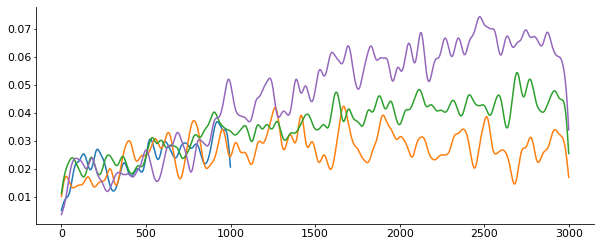

In [55]:
ker = KernelFun.gaussian_delta(20)

psth_d = np.mean(st_train.convolve(ker), 1)
psth_fr_mmd = np.mean(st_fr_mmd_long.convolve(ker), 1)
psth_fr_ml = np.mean(st_fr_ml_long.convolve(ker), 1)
psth_inh = np.mean(st_inh.convolve(ker), 1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(psth_d, color=palette['d'])
ax.plot(psth_fr_mmd, color=palette['mmd'])
ax.plot(psth_fr_ml, color=palette['ml'])
ax.plot(psth_inh, color=palette['chen'])

In [25]:
z, ks = time_rescale_transform(dt, mask_spikes_train, r_train_dc_ml)
values, bins = np.histogram(np.concatenate(z), bins=100)
z_cum = np.append(0., np.cumsum(values) / np.sum(values))
# z_cum = np.cumsum(z) / np.sum(z)
# vals, bins = np.histogram(, density=True)



# plt.plot(bins[:-1], vals, '-')

In [100]:
z_cum

array([0.        , 0.10434783, 0.16956522, 0.26521739, 0.39130435,
       0.47391304, 0.5826087 , 0.6826087 , 0.77391304, 0.8826087 ,
       1.        ])

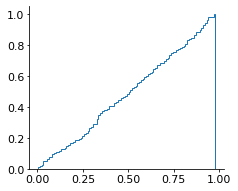

In [88]:
plt.hist(np.concatenate(z), density=True, histtype='step', cumulative=True, bins=100);